# Learnable Fourier Features for Multi-Dimensional Spatial Positional Encoding

https://arxiv.org/abs/2106.02795

In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt


### Pytorch

In [2]:
# Credits: https://github.com/willGuimont/learnable_fourier_positional_encoding

class LearnableFourierPositionalEncoding(nn.Module):
    def __init__(self, G: int, M: int, F_dim: int, H_dim: int, D: int, gamma: float):
        """
        Learnable Fourier Features from https://arxiv.org/pdf/2106.02795.pdf (Algorithm 1)
        Implementation of Algorithm 1: Compute the Fourier feature positional encoding of a multi-dimensional position
        Computes the positional encoding of a tensor of shape [N, G, M]
        :param G: positional groups (positions in different groups are independent)
        :param M: each point has a M-dimensional positional values
        :param F_dim: depth of the Fourier feature dimension
        :param H_dim: hidden layer dimension
        :param D: positional encoding dimension
        :param gamma: parameter to initialize Wr
        """
        super().__init__()
        self.G = G
        self.M = M
        self.F_dim = F_dim
        self.H_dim = H_dim
        self.D = D
        self.gamma = gamma

        # Projection matrix on learned lines (used in eq. 2)
        self.Wr = nn.Linear(self.M, self.F_dim // 2, bias=False)
        # MLP (GeLU(F @ W1 + B1) @ W2 + B2 (eq. 6)
        self.mlp = nn.Sequential(
            nn.Linear(self.F_dim, self.H_dim, bias=True),
            nn.ReLU(),
            nn.Linear(self.H_dim, self.D // self.G, bias=True)
        )

        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.Wr.weight.data, mean=0, std=self.gamma ** -2)

    def forward(self, x):
        """
        Produce positional encodings from x
        :param x: tensor of shape [N, G, M] that represents N positions where each position is in the shape of [G, M],
                  where G is the positional group and each group has M-dimensional positional values.
                  Positions in different positional groups are independent
        :return: positional encoding for X
        """
        N, G, M = x.shape
        # Step 1. Compute Fourier features (eq. 2)
        projected = self.Wr(x)
        cosines = torch.cos(projected)
        sines = torch.sin(projected)
        F = 1.0 / np.sqrt(self.F_dim) * torch.cat([cosines, sines], dim=-1)
        # Step 2. Compute projected Fourier features (eq. 6)
        Y = self.mlp(F)
        # Step 3. Reshape to x's shape
        PEx = Y.reshape((N, self.D))
        return PEx

In [3]:
num_points = 200
positional_groups = 3  # positional groups ?
point_dimension = 3    # x, y, z
x_np = np.random.normal(size=(num_points, positional_groups, point_dimension))

torch.Size([200, 768])


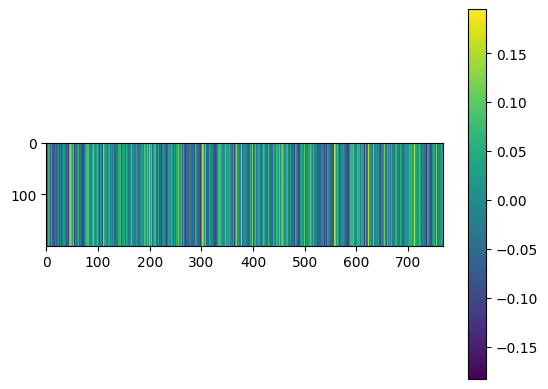

In [4]:
f_dim = 768            # depth of the Fourier dimension
h_dim = 32             # hidden layer
positional_encoding_dimension = 768
gamma = 10             # ?


x = torch.Tensor(x_np)

enc = LearnableFourierPositionalEncoding(positional_groups, point_dimension, f_dim, h_dim, positional_encoding_dimension, gamma)
pex = enc(x)
print(pex.shape)
plt.imshow(pex.detach().numpy())
plt.colorbar()

### Tensorflow

In [5]:
import tensorflow as tf

class LearnableFourierPositionalEncodingTF(tf.keras.layers.Layer):
    def __init__(self, G, M, F_dim, H_dim, D, gamma):
        super(LearnableFourierPositionalEncodingTF, self).__init__()
        self.G = G
        self.M = M
        self.F_dim = F_dim
        self.H_dim = H_dim
        self.D = D
        self.gamma = gamma

        self.Wr = tf.keras.layers.Dense(F_dim // 2, use_bias=False)
        
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(H_dim, use_bias=True),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(D // G, use_bias=True)
        ])

        self.init_weights()

    def init_weights(self):
        initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=self.gamma ** -2)
        self.Wr.build((None, self.M))
        self.Wr.kernel.assign(initializer(self.Wr.kernel.shape))

    def call(self, x):
        N, G, M = x.shape
        projected = self.Wr(x)
        cosines = tf.cos(projected)
        sines = tf.sin(projected)
        F = 1.0 / np.sqrt(self.F_dim) * tf.concat([cosines, sines], axis=-1)
        Y = self.mlp(F)
        PEx = tf.reshape(Y, (N, self.D))
        return PEx


2023-06-15 18:35:45.431809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 18:35:45.952572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
enc_tf = LearnableFourierPositionalEncodingTF(positional_groups, point_dimension, f_dim, h_dim, positional_encoding_dimension, gamma)

2023-06-15 18:35:46.540525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-15 18:35:46.540766: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:

enc_tf(tf.convert_to_tensor(x_np)) # build layer

# tensorflow
for w in enc_tf.get_weights():
    print(w.shape)

# PyTorch
for w in enc.parameters():
    print(w.shape)

# transfer weights from Pytorch Layer to Tensorflow Layer to compare computations
enc_tf.Wr.set_weights([enc.Wr.weight.detach().numpy().T])
enc_tf.mlp.layers[0].set_weights([enc.mlp[0].weight.detach().numpy().T, enc.mlp[0].bias.detach().numpy()])
enc_tf.mlp.layers[2].set_weights([enc.mlp[2].weight.detach().numpy().T, enc.mlp[2].bias.detach().numpy()])

(3, 384)
(768, 32)
(32,)
(32, 256)
(256,)
torch.Size([384, 3])
torch.Size([32, 768])
torch.Size([32])
torch.Size([256, 32])
torch.Size([256])


(200, 768)


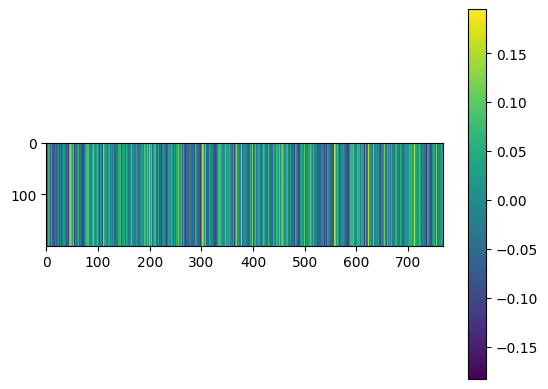

In [8]:

x = tf.convert_to_tensor(x_np)
pex_tf = enc_tf(x)
print(pex_tf.shape)
plt.imshow(pex_tf)
plt.colorbar()

In [9]:
pex_tf - pex.detach().numpy()

<tf.Tensor: shape=(200, 768), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.4505806e-09, -3.7252903e-09,  7.4505806e-09],
       [ 0.0000000e+00,  7.4505806e-09,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00, -7.4505806e-09],
       [ 1.4901161e-08,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -3.7252903e-09,  0.0000000e+00]], dtype=float32)>

In [10]:
print(tf.reduce_sum(pex_tf - pex.detach().numpy()))

tf.Tensor(1.8272549e-06, shape=(), dtype=float32)
